## Create PLY File

In [4]:
import numpy
vertex = numpy.array([(0, 0),
                      (0, 1),
                      (1, 1),
                      (1, 0),
                      (2, 1),
                      (2, 0)],
                      dtype=[('x', 'f4'), ('y', 'f4')])

face = numpy.array([([0, 1, 2, 3], 255, 255, 255),
                    ([3, 2, 4, 5], 0, 255, 255)],
                    dtype=[('vertex_indices', 'i4', (4,)),
                           ('red', 'u1'), ('green', 'u1'),
                           ('blue', 'u1')])

In [5]:
from plyfile import PlyData, PlyElement
v = PlyElement.describe(vertex, 'vertex_list')
f = PlyElement.describe(face, 'face_list')
PlyData([v, f], text = True).write('two_square_2d.ply')

## Read  PLY File

In [6]:
plydata = PlyData.read('two_square_2d.ply')

In [7]:
plydata.elements[0].data[0][0] - 1

-1.0

In [8]:
plydata.elements[1].data

array([(array([0, 1, 2, 3]), 255, 255, 255),
       (array([3, 2, 4, 5]),   0, 255, 255)],
      dtype=[('vertex_indices', 'O'), ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')])

## DCEL

In [1]:
from math import acos
from math import sqrt
from math import pi

def length(v):
    return sqrt(v[0]**2+v[1]**2)
def dot_product(v,w):
    return v[0]*w[0]+v[1]*w[1]
def determinant(v,w):
    return v[0]*w[1]-v[1]*w[0]
def inner_angle(v,w):
    cosx=dot_product(v,w)/(length(v)*length(w))
    rad=acos(cosx) # in radians
    return rad*180/pi # returns degrees
def angle_counterclockwise(A, B):
    inner=inner_angle(A,B)
    det = determinant(A,B)
    if det<0: #this is a property of the det. If the det < 0 then B is clockwise of A
        return 360-inner
    else: # if the det > 0 then A is immediately clockwise of B
        return inner

In [24]:
class Vertex:
    def __init__(self, coordinates=None, incident_edge=None, event_type=1):
        self.coordinates = coordinates
        self.incident_edge = incident_edge
        self.involves_both = False
        self.belong_to = None
        # Dinh nghia 1 la chi thuoc 1 dcel
        # 2 la giao 2 doan thuoc 2 dcel
        # 3 la 1 doan cua dcel di qua dinh cua dcel khac
        # 4 la 2 dinh cua 2 dcel trung nhau
        self.event_type = event_type
        self.left_hedge = None
    
    def find_hedges_w_origin(self):
        edges = [self.incident_edge]
        current = self.incident_edge
        while True:
            if self.incident_edge == current.twin.next:
                break
            current = current.twin.next
            edges.append(current)
        return edges
    
    def find_hedges_w_des(self):
        edges = [self.incident_edge.twin]
        current = self.incident_edge.twin
        while True:
            if self.incident_edge.twin == current.next.twin:
                break
            current = current.next.twin
            edges.append(current)
        return edges

    def __repr__(self):
        return str(self.coordinates)
                
    def __eq__(self, other):
        if isinstance(other, Vertex):
            return np.linalg.norm([self.coordinates[0] - other.coordinates[0], self.coordinates[1] - other.coordinates[1]]) < 1e-4
        return False
    
    def __hash__(self):
        return hash(self.coordinates)
             
class Face:
    def __init__(self, outer_component=None, name=None):
        self.outer_component = outer_component
        self.inner_components = []
        self.segment = None
        self.belong_to = None
        self.name = name

    def __repr__(self):
        return ('Face{outer='+(str(self.outer_component) if self.outer_component is not None else 'none'))+',inner='+str(self.inner_components)+'}'

class HalfEdge:
    def __init__(self, origin=None):
        self.origin = origin
        self.twin = None
        self.incident_face = None
        self.next = None
        self.prev = None
        self.belong_to = None
        self.cycle = None
        self.has_twin = False
    
    def __repr__(self):
        return ('HalfEdge{O=' + str(self.origin) + ', D=' + (str(self.next.origin) if self.next is not None else 'none')) + '}'

    def copy_next(self, he):
        self.next = he.next
        self.prev = he.prev
        self.incident_face = he.incident_face

    def set_next(self, he):
        self.next = he
        he.prev = self

    def set_prev(self, he):
        self.prev = he
        he.next = self

    def set_twin(self, he):
        self.twin = he
        he.twin = self
        self.has_twin = True

    def cal_angle(self):
        if self.next is None or self.next.origin is None:
            return None
        x1, y1 = self.origin.coordinates
        x2, y2 = self.next.origin.coordinates
        angle = np.arctan2(y2-y1, x2-x1)*180/np.pi
        if angle <= 0:
            angle += 360
        return angle

    def clockwise_angle(self, he):
        x1, y1 = self.origin.coordinates
        x2, y2 = self.next.origin.coordinates
        x_v2, y_v2 = (x2-x1, y2-y1)
        x3, y3 = he.origin.coordinates
        x4, y4 = he.next.origin.coordinates
        x_v1, y_v1 = (x4-x3, y4-y3)
        dot = x_v1*x_v2 + y_v1*y_v2
        det = x_v1*y_v2 - y_v1*x_v2
        angle = np.arctan2(-det, -dot) + np.pi
        if angle >= 2*np.pi or angle < 0:
            angle = 0
        return angle*180/np.pi
    
    def inside_angle(self, next_he):
        return self.twin.clockwise_angle(next_he)


In [25]:
import numpy as np
import matplotlib.cm as cm
class DCEL():
    def __init__(self):
        self.vertices = []
        self.faces = []
        self.halfedges = []
        
    def __construct_bounded_face__(self, triangulation):
        for coordinates in triangulation.points:
            vertex = Vertex(coordinates)
            self.vertices.append(vertex)
            
        for face in triangulation.simplices:
            # create edge list constructing a face
            edges = []
            half_edges = []
            for i in range(len(face)):
                if i < len(face)-1:
                    edges.append((face[i], face[i+1]))
                else:
                    edges.append((face[i], face[0]))

            for edge in edges:
                half_edge = HalfEdge(self.vertices[edge[0]])
                self.vertices[edge[0]].incidence_edge = half_edge
                half_edges.append(half_edge)
                
            face = Face(half_edges[0])
            self.faces.append(face)
            
            # set next and prev pointer of half-edges in half_edges
            for i in range(len(half_edges)):
                
                if i == 0:
                    half_edges[i].next = half_edges[i+1]
                    half_edges[i].prev = half_edges[-1]
                    half_edges[i].incidence_face = face
                elif i == len(half_edges)-1:
                    half_edges[i].next = half_edges[0]
                    half_edges[i].prev = half_edges[i-1]
                    half_edges[i].incidence_face = face
                else:
                    half_edges[i].next = half_edges[i+1]
                    half_edges[i].prev = half_edges[i-1]
                    half_edges[i].incidence_face = face
                    
            for hf in half_edges:
                self.halfedges.append(hf)
            
    def __construct_twin__(self, triangulation):
        self.__construct_bounded_face__(triangulation)
        #Sequentially pick half edge a from half_edge list, check if there exist another half b edge that has its end is a's origin
        #and it's origin is a's end, set a and b are twin of each other.
        for i in range(len(self.halfedges)):
            a = self.halfedges[i]
            if a.has_twin:
                continue
            a_origin = a.origin
            a_end = a.next.origin
            for hf in self.halfedges[i+1:]:
                b_origin = hf.origin
                b_end = hf.next.origin
                if a_origin == b_end and a_end == b_origin:
                    b = hf
                    a.set_twin(b)
                    b.set_twin(a)
                    break
                    
    def __construct_unbounded_face__(self, triangulation):
        self.__construct_twin__(triangulation)
        # for every hafl edge that doesnt have twin edge, find its next by searching for a half edge whose end is its origin
        # and also doesn't have a twin.
        unbounded_face = Face()
        
        without_twin_list = []
        for hf in self.halfedges:
            if not hf.has_twin:
                without_twin_list.append(hf)

        while len(without_twin_list) != 0:
            starting_hf = without_twin_list[0] #take a arbitrary half edge
            end = starting_hf.next.origin
            origin = starting_hf.origin

            
            starting_twin_hf = HalfEdge(end)
            starting_twin_hf.set_twin(starting_hf)
            starting_hf.set_twin(starting_twin_hf)
            
            current_twin_edge = starting_twin_hf
            self.halfedges.append(starting_twin_hf)
            rm_list = [starting_hf]
            
            while current_twin_edge.next is None:
                candidates = []
                for hf in without_twin_list:
                    end_hf = hf.next.origin
                    if end_hf == origin and not hf.has_twin:
                        candidates.append(hf)
                
                if candidates == []:
                    break
                        
                v1 = end.coordinates - origin.coordinates
                angles = []
                for c in candidates:
                    v2 = c.origin.coordinates - c.next.origin.coordinates
                    counterclockwise_angle = angle_counterclockwise(v1, v2)
                    angles.append(counterclockwise_angle)
                
                index = angles.index(max(angles))
                winner = candidates[index] #^^#
                
                twin_winner = HalfEdge(origin)
                twin_winner.set_twin(winner)
                winner.set_twin(twin_winner)
                
                current_twin_edge.next = twin_winner
                twin_winner.prev = current_twin_edge
                
                current_twin_edge = twin_winner
                rm_list.append(winner)
                origin = winner.origin
                end = winner.next.origin
                self.halfedges.append(twin_winner)
            
            starting_twin_hf = starting_hf.twin
            current_twin_edge.set_next(starting_twin_hf)
            starting_twin_hf.set_prev(current_twin_edge)

            unbounded_face.add_inner_component(rm_list[0])
            for hf in rm_list:
                without_twin_list.remove(hf)
            
            
        self.faces.append(unbounded_face)
                        
    def plot_dcel(self, ax=None):
        if ax is not None:
            splt = ax
        else:
            splt = plt.subplot()
        def detect_cycle():
            cycles = []
            he_set = set(self.halfedges)
            while len(he_set) != 0:
                first_he = he_set.pop()
                current_cycle = [first_he]
                current_he = first_he
                while current_he.next != first_he:
                    current_he = current_he.next
                    he_set.remove(current_he)
                    current_cycle.append(current_he)
                cycles.append(current_cycle)
            return cycles

        def shift_left_he(halfedge):
            x1, y1 = halfedge.origin.coordinate
            x2, y2 = halfedge.next.origin.coordinate
            v = np.array([x2-x1, y2-y1])
            xv, yv = v
            norm = np.linalg.norm([xv, yv])
            a = np.array([[xv, yv], [-yv, xv]])
            b = [0, 0.03*norm]
            dx, dy = np.linalg.solve(a,b)
            dxv, dyv = v/norm*0.03
            return x1+dx+dxv, y1+dy+dyv, x2-x1-2*dxv, y2-y1-2*dyv
        cycles = detect_cycle()
        #splt.set_aspect('equal', 'datalim')
        splt.set_aspect('equal',adjustable='box')
        splt.set_xlim(min([p.coordinates[0] for p in self.vertices]) - 1, max([p.coordinates[0] for p in self.vertices]) + 1)
        splt.set_ylim(min([p.coordinates[1] for p in self.vertices]) - 1, max([p.coordinates[1] for p in self.vertices]) + 1)
        color = iter(cm.rainbow(np.linspace(0,1,len(cycles))))
        he_list = set(self.halfedges)
        for cycle in cycles:
            c = next(color)
            for he in cycle:
                splt.quiver(*shift_left_he(he), scale=1, scale_units='xy', angles='xy', color=c, width=0.002, headwidth=7)
        for face in self.faces:
            if face.outer_component is not None and face.name is not None:
                first_he = face.outer_component
                current_he = face.outer_component
                list_he = [face.outer_component]
                while current_he.next != first_he:
                    current_he = current_he.next
                    list_he.append(current_he)
                x_max = max([he.origin.coordinates[0] for he in list_he])
                x_min = min([he.origin.coordinates[0] for he in list_he])
                y_max = max([he.origin.coordinates[1] for he in list_he])
                y_min = min([he.origin.coordinates[1] for he in list_he])
                cx = (x_max+x_min)/2
                cy = (y_max+y_min)/2
                splt.annotate(face.name, (cx, cy), color='black', weight='bold', 
                    fontsize=6, ha='center', va='center')
            elif face.name is not None:
                splt.set_title('Outer face: ' + face.name)
        if ax is None:
            plt.show()
            
    def construct_from_triangulation(self, triangulation):
        self.__construct_unbounded_face__(triangulation)

## Generate Random Plannar Graph

In [26]:
from scipy.spatial import Delaunay
import matplotlib.pyplot as plt
def dcel_triangulation(num_vertex):
    points = np.random.rand(num_vertex, 2) * num_vertex * 3
    tri = Delaunay(points)

    la = DCEL()
    la.construct_from_triangulation(tri)
    return la

In [27]:
ten_vertex_graph_1 = dcel_triangulation(10)

AttributeError: 'Face' object has no attribute 'add_inner_component'

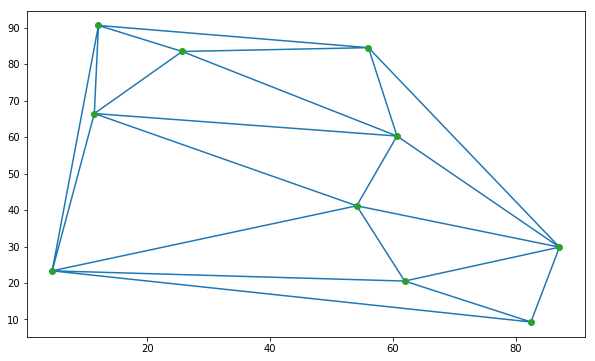

Populating the interactive namespace from numpy and matplotlib


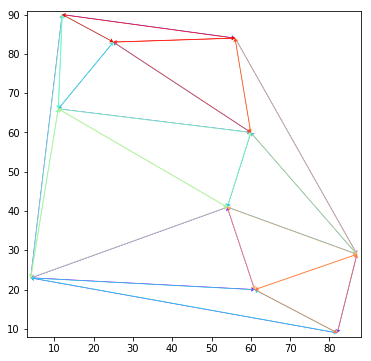

In [20]:
ten_vertex_graph_2 = dcel_triangulation(10)

In [21]:
import pickle

pickle.dump((ten_vertex_graph_1, ten_vertex_graph_2), open("./test_case/20_vertex_overlay.p", "wb"))

In [40]:
for i in range (11):
    planar_graph_1 = dcel_triangulation(15 *i + 5)
    planar_graph_2 = dcel_triangulation(15 *i + 5)
    pickle.dump((planar_graph_1, planar_graph_2), open("./test_case/" + str(30*i + 10) + "_vertex_overlay.p", "wb"))

In [ ]:
om